In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 0. Importing & Joining Data

In [2]:
# Load the datasets
properties = pd.read_csv('properties_2016.csv')
train = pd.read_csv('train_2016_v2.csv')

# Join the datasets on the 'parcelid' column
merged_data = pd.merge(train, properties, on='parcelid', how='left')

C:\Users\Yash Joshi\AppData\Local\Temp\ipykernel_14196\3754646456.py:2: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  properties = pd.read_csv('properties_2016.csv')


In [3]:
merged_data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [4]:
merged_data['latitude'] = merged_data['latitude']/1000000
merged_data['longitude'] = merged_data['longitude']/1000000

# 1. EDA

# 1 A - Visualizing the target variable

Log error with top and bottom 1%ile clipped off

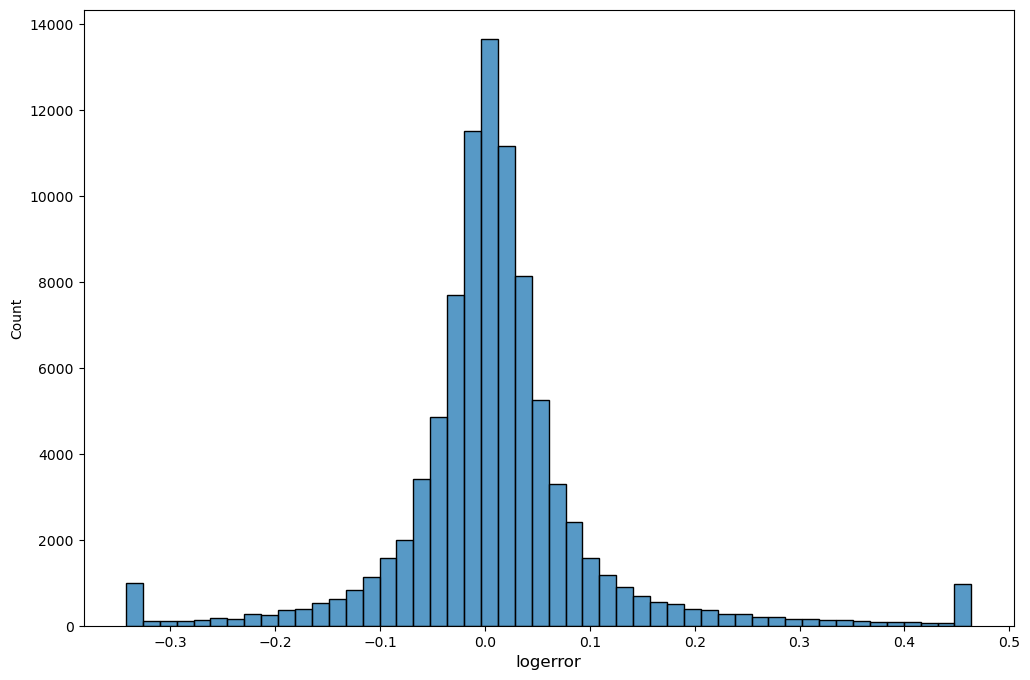

In [5]:
# Calculate the 1st and 99th percentiles of the 'logerror' column
llimit = np.percentile(merged_data['logerror'].values, 1)
ulimit = np.percentile(merged_data['logerror'].values, 99)

# Clip values outside the 1st and 99th percentiles
merged_data['temperror'] = np.clip(merged_data['logerror'], llimit, ulimit)

# Plot the histogram of the 'logerror' values
plt.figure(figsize=(12, 8))
sns.histplot(merged_data['temperror'], bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

merged_data = merged_data.drop('temperror', axis=1)

In [6]:
merged_data['logerror'].describe()

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64

In [7]:
!pip install h3 folium geopandas shapely

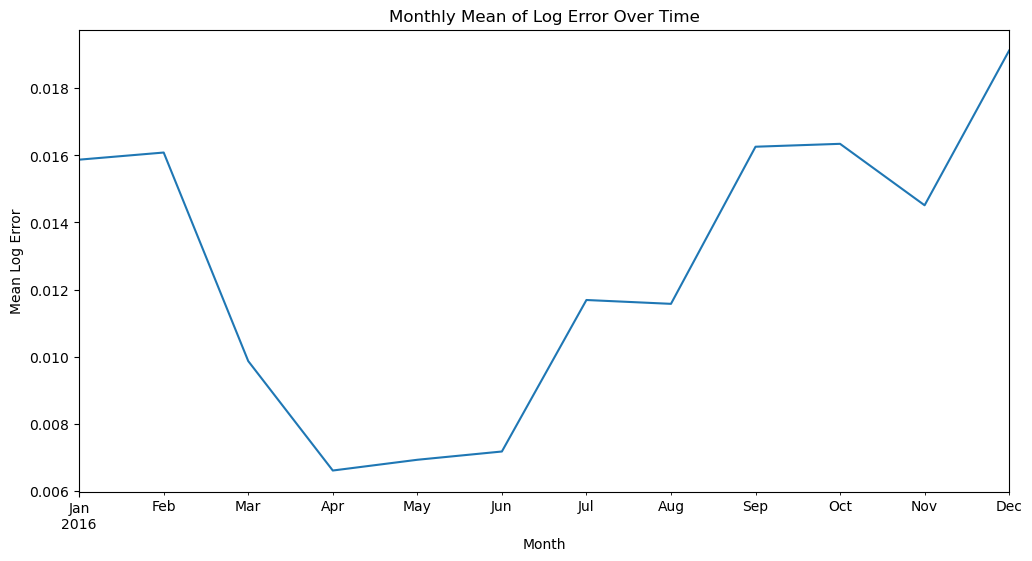

In [8]:
# Setting date as index
merged_data['transactiondate'] = pd.to_datetime(merged_data['transactiondate'])
merged_data.set_index('transactiondate', inplace=True)


# Resample data by week and calculate mean logerror
weekly_logerror_mean = merged_data['logerror'].resample('M').mean()

# Plotting the weekly mean logerror
plt.figure(figsize=(12, 6))
weekly_logerror_mean.plot()
plt.title('Monthly Mean of Log Error Over Time')
plt.xlabel('Month')
plt.ylabel('Mean Log Error')
plt.show()

In [9]:
import pandas as pd
import folium
import h3
import geopandas as gpd
import shapely.geometry  

# Assuming merged_data is your DataFrame with 'latitude', 'longitude', and 'logerror'

# Convert data to a GeoDataFrame
gdf = gpd.GeoDataFrame(merged_data, geometry=gpd.points_from_xy(merged_data['longitude'], merged_data['latitude']))

# Define hexagon resolution
hex_resolution = 4  # Adjust as needed

# Assign each point to a hexagon
gdf['hex'] = gdf.apply(lambda row: h3.geo_to_h3(row['latitude'], row['longitude'], hex_resolution), axis=1)

# Calculate average logerror for each hexagon
hex_avg_logerror = gdf.groupby('hex')['logerror'].mean()


# Initialize a map
m = folium.Map(location=[merged_data['latitude'].mean(), merged_data['longitude'].mean()], 
               zoom_start=8, 
               tiles='CartoDB positron')

# Function to find the centroid of a hexagon
def get_hexagon_centroid(hex_id):
    boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    boundary_coords = [(coord[1], coord[0]) for coord in boundary]
    polygon = shapely.geometry.Polygon(boundary_coords)
    return polygon.centroid.coords[0]

# Plot hexagons with log error labels
for hex_id, avg_logerror in hex_avg_logerror.items():
    hex_boundary = h3.h3_to_geo_boundary(hex_id, geo_json=True)
    hex_boundary = [(h[1], h[0]) for h in hex_boundary]
    # Ensure the boundary is closed for folium Polygon
    if hex_boundary[0] != hex_boundary[-1]:
        hex_boundary.append(hex_boundary[0])

    # Add Polygon to the map
    folium.vector_layers.Polygon(locations=hex_boundary,
                                 fill=True,
                                 color='blue',
                                 fill_opacity=abs(avg_logerror) * 1.5,  # Adjust opacity as needed
                                 ).add_to(m)

    # Calculate centroid and add a label
    centroid = get_hexagon_centroid(hex_id)
    folium.map.Marker(
        centroid,
        icon=folium.DivIcon(
            html=f'<div style="font-size: 8pt; color : black">{avg_logerror:.2f}</div>'
        )
    ).add_to(m)

# Display the map
m


# 1B - Exploring predictors - Distribution

In [10]:
# Select the columns you're interested in
features = ['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt']  # Add or remove features as needed
descriptive_stats = merged_data[features].describe()
print(descriptive_stats)


        bathroomcnt    bedroomcnt  taxvaluedollarcnt
count  90275.000000  90275.000000       9.027400e+04
mean       2.279474      3.031869       4.576726e+05
std        1.004271      1.156436       5.548844e+05
min        0.000000      0.000000       2.200000e+01
25%        2.000000      2.000000       1.990232e+05
50%        2.000000      3.000000       3.428720e+05
75%        3.000000      4.000000       5.405890e+05
max       20.000000     16.000000       2.775000e+07


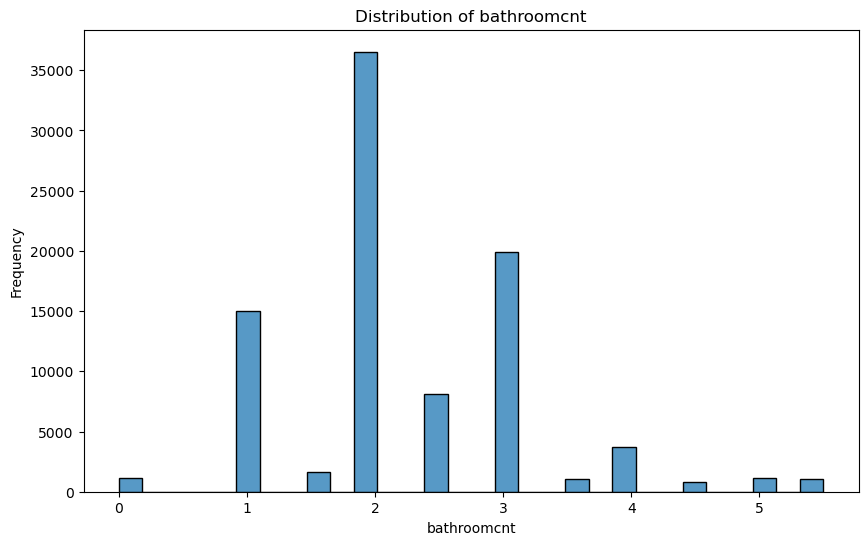

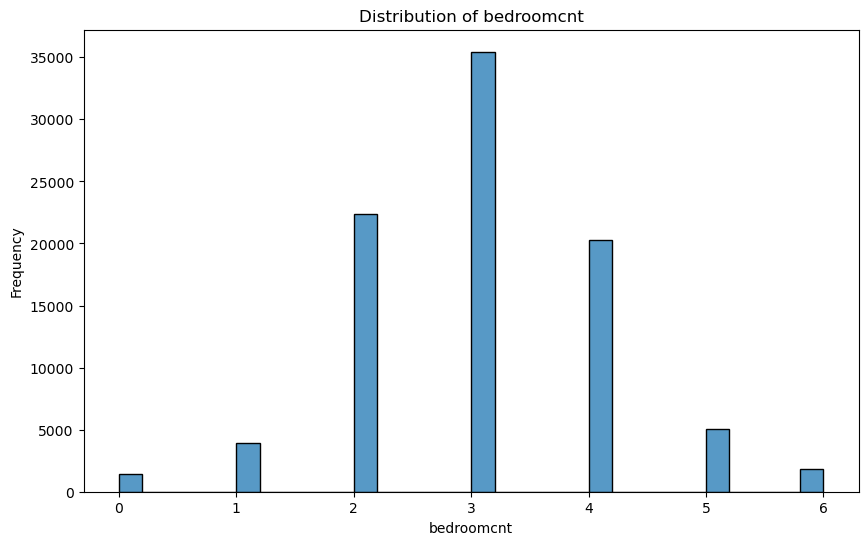

C:\Users\Yash Joshi\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return bound(*args, **kwds)


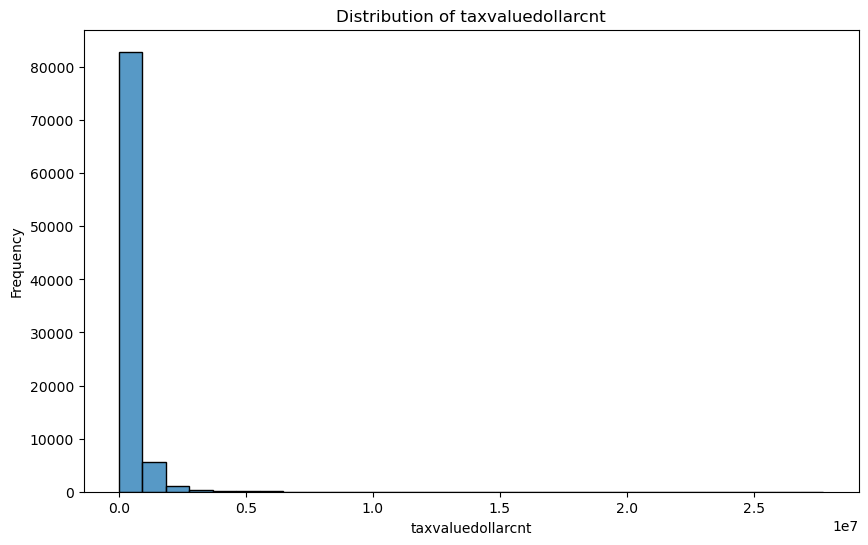

In [11]:
#Log error with top and bottom 1%ile clipped off

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Replace 'merged_data' with your actual DataFrame variable
# Ensure 'merged_data' has columns 'bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt'

features = ['bathroomcnt', 'bedroomcnt', 'taxvaluedollarcnt']  # List of features to plot

for feature in features:
    # Calculate the 1st and 99th percentiles of each feature
    llimit = np.percentile(merged_data[feature].values, 1)
    ulimit = np.percentile(merged_data[feature].values, 99)

    # Clip values outside the 1st and 99th percentiles and create a temporary column
    temp_col_name = f'temp_{feature}'
    merged_data[temp_col_name] = np.clip(merged_data[feature], llimit, ulimit)

    # Plot the histogram of the temporary column values
    plt.figure(figsize=(10, 6))
    sns.histplot(merged_data[temp_col_name], bins=30, kde=False)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

    # Drop the temporary column from the DataFrame
    merged_data.drop(temp_col_name, axis=1, inplace=True)


# 1B - Exploring predictors - Null Values

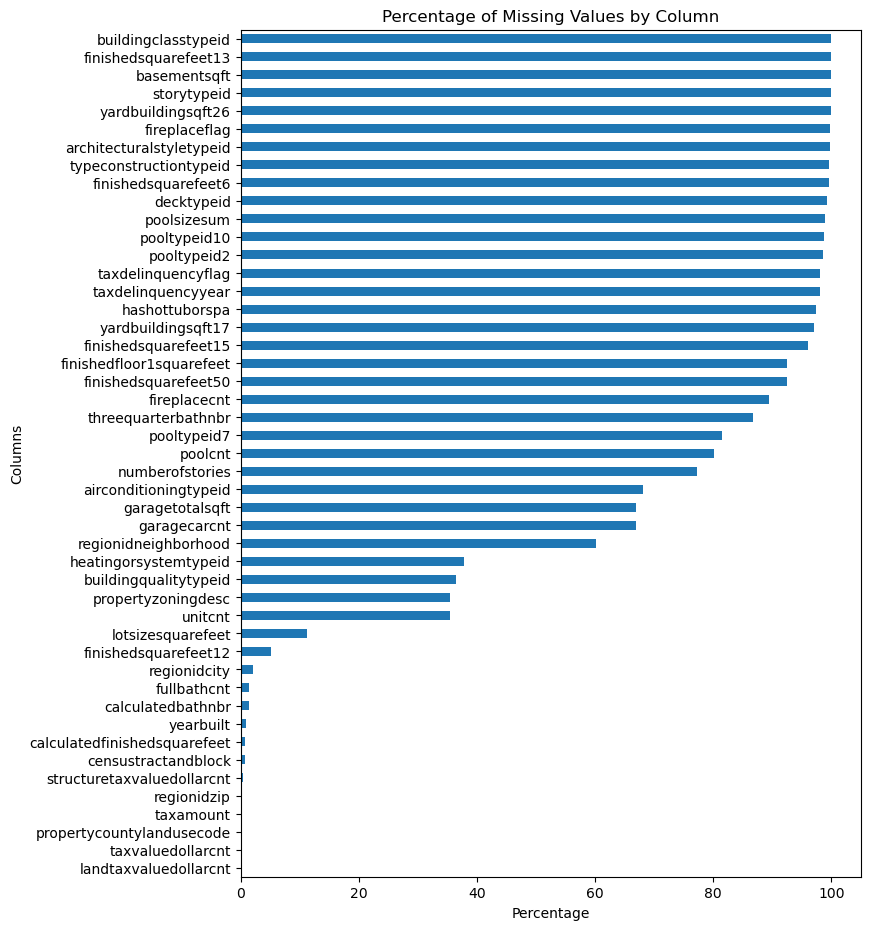

In [12]:
# Calculate the percentage of missing values in each column
missing_percentages = merged_data.isnull().mean() * 100

# Filter out columns that have no missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Check if there are any columns with missing values to plot
if missing_percentages.empty:
    print("No missing values found in any column.")
else:
    # Plotting
    plt.figure(figsize=(8, 11))
    missing_percentages.sort_values().plot(kind='barh')
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Percentage')
    plt.ylabel('Columns')
    plt.show()

# 1 C - Exploring predictor variable correlations with target variable

Visualizing by each category for better insights

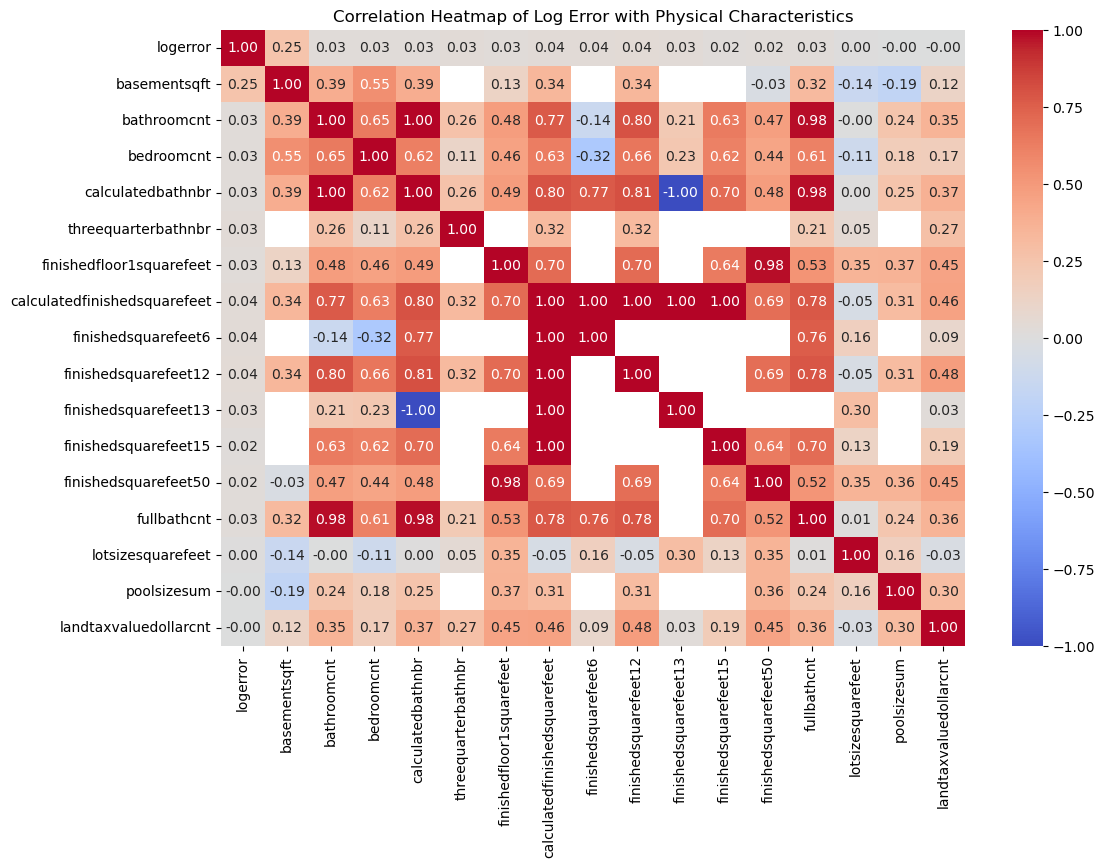

C:\Users\Yash Joshi\AppData\Local\Temp\ipykernel_14196\2808939853.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  category_corr = merged_data[relevant_columns].corr()


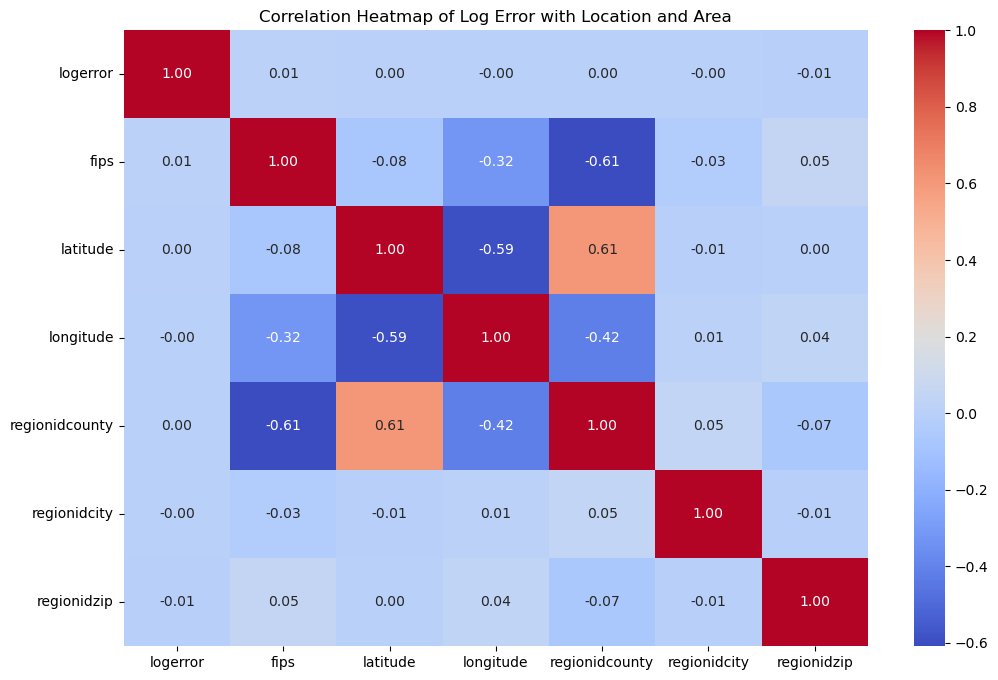

C:\Users\Yash Joshi\AppData\Local\Temp\ipykernel_14196\2808939853.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  category_corr = merged_data[relevant_columns].corr()


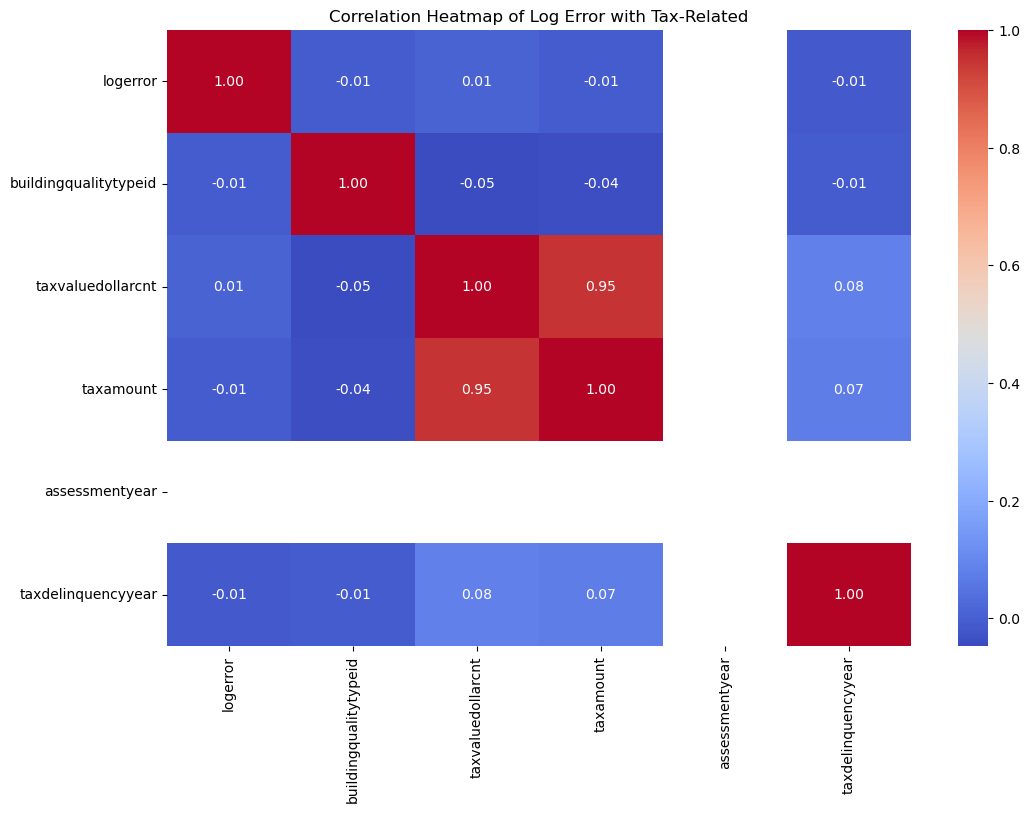

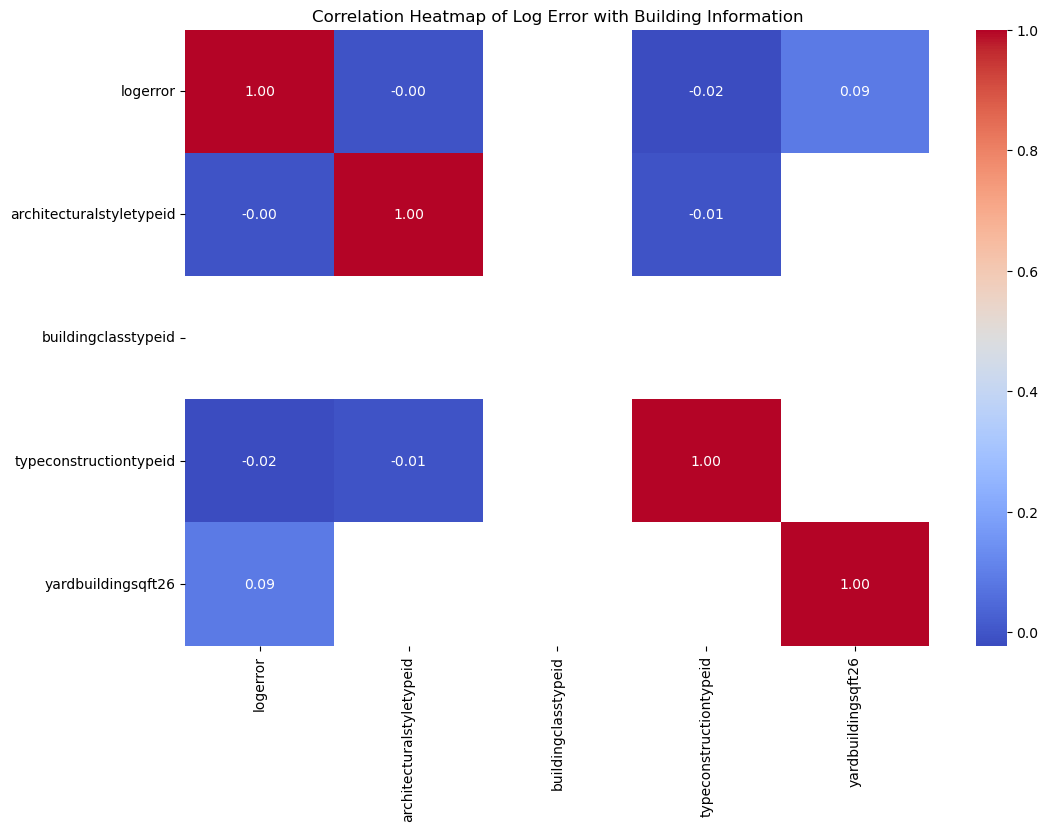

C:\Users\Yash Joshi\AppData\Local\Temp\ipykernel_14196\2808939853.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  category_corr = merged_data[relevant_columns].corr()


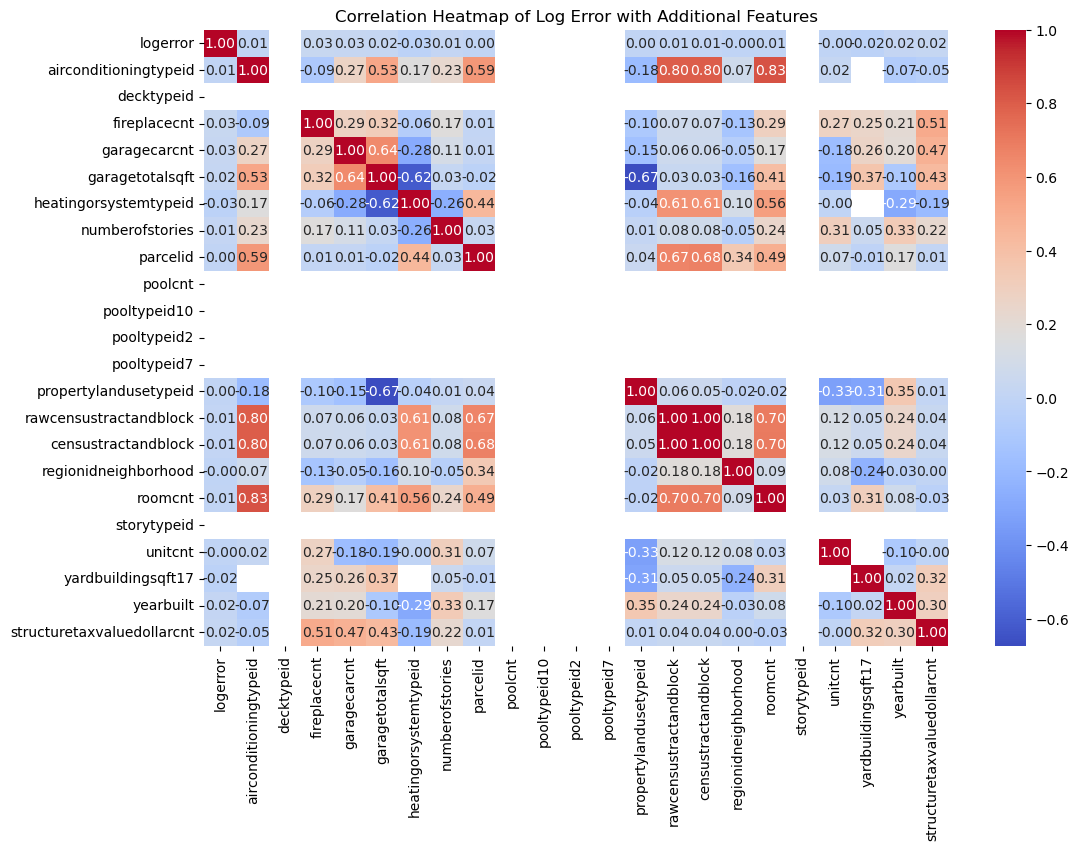

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define the feature categories based on the earlier classification
physical_characteristics = ['basementsqft', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr', 'threequarterbathnbr', 'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet', 'finishedsquarefeet6', 'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'fullbathcnt', 'lotsizesquarefeet', 'poolsizesum', 'landtaxvaluedollarcnt']
location_area = ['fips', 'latitude', 'longitude', 'propertycountylandusecode', 'regionidcounty', 'regionidcity', 'regionidzip']
tax_related = ['buildingqualitytypeid', 'taxvaluedollarcnt', 'taxamount', 'assessmentyear', 'taxdelinquencyflag', 'taxdelinquencyyear']
building_info = ['architecturalstyletypeid', 'buildingclasstypeid', 'typeconstructiontypeid', 'yardbuildingsqft26']
additional_features = ['airconditioningtypeid', 'decktypeid', 'fireplacecnt', 'fireplaceflag', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'heatingorsystemtypeid', 'numberofstories', 'parcelid', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'propertylandusetypeid', 'propertyzoningdesc', 'rawcensustractandblock', 'censustractandblock', 'regionidneighborhood', 'roomcnt', 'storytypeid', 'unitcnt', 'yardbuildingsqft17', 'yearbuilt', 'structuretaxvaluedollarcnt']

# Function to plot correlation heatmap for a category
def plot_corr_heatmap(category, category_name):
    # Select relevant columns for the category, including logerror
    relevant_columns = ['logerror'] + [col for col in category if col in merged_data.columns]
    category_corr = merged_data[relevant_columns].corr()

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(category_corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Heatmap of Log Error with {category_name}')
    plt.show()

# Plot correlation heatmaps for each category
plot_corr_heatmap(physical_characteristics, 'Physical Characteristics')
plot_corr_heatmap(location_area, 'Location and Area')
plot_corr_heatmap(tax_related, 'Tax-Related')
plot_corr_heatmap(building_info, 'Building Information')
plot_corr_heatmap(additional_features, 'Additional Features')


# 2. Data Cleaning

## 2 A - Recovering missing Location Data

## Here is an example of why KNN can be used

In [14]:
missing_city_row = merged_data[merged_data['regionidcity'].isnull()].iloc[4]

In [15]:
lat = missing_city_row['latitude']
long = missing_city_row['longitude']

In [16]:
# Example radius in degrees (this will depend on your specific needs and data)
radius = 0.01  # This is an arbitrary value, adjust as needed

neighbors = merged_data[(merged_data['latitude'] >= lat - radius) & 
                        (merged_data['latitude'] <= lat + radius) &
                        (merged_data['longitude'] >= long - radius) & 
                        (merged_data['longitude'] <= long + radius)]

In [17]:
map_data = neighbors[['latitude', 'longitude', 'regionidcity']]

In [18]:
import folium

# Create a map
map_center = [lat, long]
map = folium.Map(location=map_center, zoom_start=14)

# Add a marker for the missing data point
folium.CircleMarker(location=[lat, long], radius=5, color='red', fill=True, popup='Missing regionidcity').add_to(map)

# Add markers for neighbors with popups for non-null regionidcity
for index, row in map_data.iterrows():
    color = 'blue'
    popup_text = f"regionidcity: {row['regionidcity']}" if pd.notnull(row['regionidcity']) else "regionidcity: Missing"
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=3, color=color, fill=True, popup=popup_text).add_to(map)

# Display the map
map


## Code to recover missing Location Data

In [19]:
geocolumns = ['latitude', 'longitude', 'propertycountylandusecode', 'propertylandusetypeid', 
              'propertyzoningdesc', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 
              'regionidzip', 'censustractandblock', 'rawcensustractandblock']

geoprop = merged_data[geocolumns]

In [20]:
# Drop rows without latitude and longitude
geoprop.dropna(axis=0, subset=['latitude', 'longitude'], inplace=True)

C:\Users\Yash Joshi\AppData\Local\Temp\ipykernel_14196\1346357283.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  geoprop.dropna(axis=0, subset=['latitude', 'longitude'], inplace=True)


In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier

def fillna_knn(df, base, target, fraction=1, threshold=10):
    assert isinstance(base, list) or isinstance(base, np.ndarray) and isinstance(target, str)
    whole = [target] + base

    miss = df[target].isnull()
    notmiss = ~miss
    nummiss = miss.sum()

    enc = OneHotEncoder()
    X_target = df.loc[notmiss, whole].sample(frac=fraction)
    
    # Fit and transform the target column
    enc.fit(X_target[target].unique().reshape((-1, 1)))
    Y = enc.transform(X_target[target].values.reshape((-1, 1))).toarray()
    X = X_target[base]

    # Fitting the KNN model
    n_neighbors = 10
    clf = KNeighborsClassifier(n_neighbors, weights='uniform')
    clf.fit(X, Y)

    # Predicting the missing values
    Z = clf.predict(df.loc[miss, base])

    # Replacing the missing values in the original dataframe
    numunpredicted = (Z == 0).all(axis=1).sum()
    if numunpredicted / nummiss * 100 < threshold:
        print('writing result to df')
        df.loc[miss, target] = np.dot(Z, enc.categories_[0])
        print('num of unpredictable data:', numunpredicted)
    else:
        print('out of threshold: {}% > {}%'.format(numunpredicted / nummiss * 100, threshold))

In [22]:
# Filling the missing values to the most missing values
merged_data.dropna(axis=0, subset=['latitude', 'longitude'], inplace=True)

fillna_knn(df=merged_data, base=['latitude', 'longitude'], target='regionidcity', fraction=0.15)

fillna_knn(df=merged_data, base=['latitude', 'longitude'], target='regionidzip', fraction=0.15)

out of threshold: 10.759844703272323% > 10%
writing result to df
num of unpredictable data: 2


## 2 - B - Missing & Unary Data

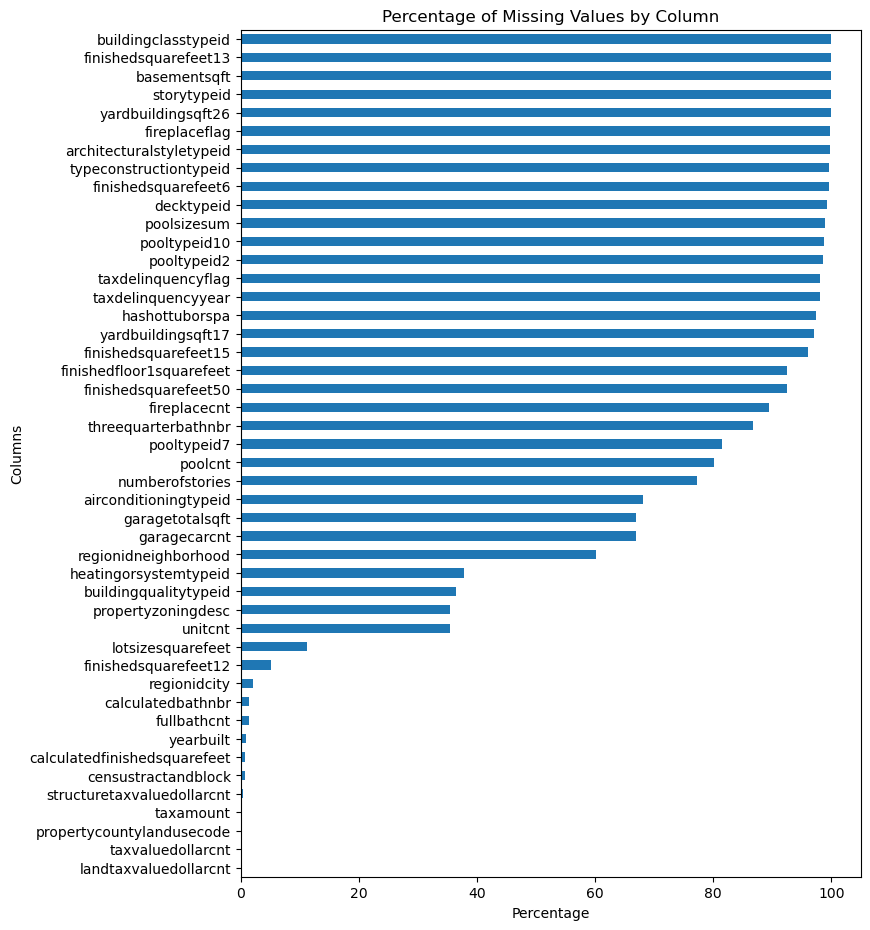

In [23]:
# Calculate the percentage of missing values in each column
missing_percentages = merged_data.isnull().mean() * 100

# Filter out columns that have no missing values
missing_percentages = missing_percentages[missing_percentages > 0]

# Check if there are any columns with missing values to plot
if missing_percentages.empty:
    print("No missing values found in any column.")
else:
    # Plotting
    plt.figure(figsize=(8, 11))
    missing_percentages.sort_values().plot(kind='barh')
    plt.title('Percentage of Missing Values by Column')
    plt.xlabel('Percentage')
    plt.ylabel('Columns')
    plt.show()

In [24]:
print ("Features with one unique value!!")
exclude_unique = []
for c in merged_data.columns:
    num_uniques = len(merged_data[c].unique())
    if merged_data[c].isnull().sum() != 0:
        num_uniques -= 1
    if num_uniques == 1:
        exclude_unique.append(c)
print(exclude_unique)

Features with one unique value!!
['buildingclasstypeid', 'decktypeid', 'hashottuborspa', 'poolcnt', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'storytypeid', 'fireplaceflag', 'assessmentyear', 'taxdelinquencyflag']


In [25]:
columns_to_drop = [
    'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedfloor1squarefeet', 
    'finishedsquarefeet50', 'storytypeid', 'buildingclasstypeid', 
    'architecturalstyletypeid', 'typeconstructiontypeid', 'finishedsquarefeet6', 
    'numberofstories', 'rawcensustractandblock', 'censustractandblock', 
    'assessmentyear', 'parcelid', 'transactiondate', 'basementsqft', 'yardbuildingsqft26'
]

# Assuming your DataFrame is named 'merged_data'
merged_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

## 2 C - Missing Value Imputation - Unary Imputation

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

In [27]:
# Impute 0
impute_0_vars = ["yardbuildingsqft17", "fireplacecnt", "poolcnt", "garagecarcnt", "garagetotalsqft",
                 "pooltypeid2", "poolsizesum", "decktypeid", "taxdelinquencyflag"]

# Impute mode
impute_mode_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "unitcnt", "fips", 
                    "propertylandusetypeid", "regionidcounty", "yearbuilt"] 

# Impute median 
impute_median_vars = ["buildingqualitytypeid", "lotsizesquarefeet", "bathroomcnt", "bedroomcnt", "calculatedfinishedsquarefeet",
                      "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt", "latitude", "longitude"]

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import pandas as pd

# Define your ColumnTransformer (as you did)
univariate_impute_pipe = ColumnTransformer([
        ("impute_0", SimpleImputer(strategy="constant", fill_value=0), impute_0_vars),
        ("impute_mode", SimpleImputer(strategy="most_frequent"), impute_mode_vars),
        ("impute_median", SimpleImputer(strategy="median"), impute_median_vars),
    ],
    remainder='passthrough'
)

# Fit and transform the data
transformed_data = univariate_impute_pipe.fit_transform(merged_data)

# Get the names of the columns transformed
transformed_columns = impute_0_vars + impute_mode_vars + impute_median_vars

# Identify columns that were 'passed through'
remainder_columns = [col for col in merged_data.columns if col not in transformed_columns]

# Combine all column names
all_columns = transformed_columns + remainder_columns

# Create DataFrame from the transformed data
merged_data = pd.DataFrame(transformed_data, columns=all_columns, index=merged_data.index)

In [28]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
import pandas as pd

# Define your column names for categorical and numerical variables
cat_impute_vars = ["airconditioningtypeid", "heatingorsystemtypeid", "fips", "propertylandusetypeid", "regionidcounty", "pooltypeid2", "decktypeid", "taxdelinquencyflag"] 
numeric_impute_vars = ["bathroomcnt", "bedroomcnt", "buildingqualitytypeid", "calculatedfinishedsquarefeet",
                  "fireplacecnt", "garagecarcnt", "garagetotalsqft", "latitude", "longitude", "lotsizesquarefeet", "poolcnt",
                  "poolsizesum", "unitcnt", "yardbuildingsqft17", "yearbuilt", "structuretaxvaluedollarcnt", "landtaxvaluedollarcnt"]

# Define your ColumnTransformer with multivariate imputation
multivariate_impute_pipe = ColumnTransformer([
        ("impute_cats", SimpleImputer(strategy="constant", fill_value='missing'), cat_impute_vars),
        ("impute_num", IterativeImputer(estimator=RandomForestRegressor(n_estimators=1, max_depth=30, min_samples_leaf=32), random_state=0, max_iter=1), numeric_impute_vars),
    ],
    remainder='passthrough'
)

# Fit and transform the data
transformed_data = multivariate_impute_pipe.fit_transform(merged_data)

# Get the names of the columns transformed
transformed_columns = cat_impute_vars + numeric_impute_vars

# Identify columns that were 'passed through'
remainder_columns = [col for col in merged_data.columns if col not in transformed_columns]

# Combine all column names
all_columns = transformed_columns + remainder_columns

# Create DataFrame from the transformed data
transformed_merged_data = pd.DataFrame(transformed_data, columns=all_columns, index=merged_data.index)

# Now transformed_merged_data is your new DataFrame with imputations

In [29]:
transformed_merged_data.reset_index()

,transactiondate,airconditioningtypeid,heatingorsystemtypeid,fips,propertylandusetypeid,regionidcounty,pooltypeid2,decktypeid,taxdelinquencyflag,bathroomcnt,...,propertyzoningdesc,regionidcity,regionidneighborhood,regionidzip,roomcnt,threequarterbathnbr,fireplaceflag,taxvaluedollarcnt,taxamount,taxdelinquencyyear
0,2016-01-01,1.0,2.0,6037.0,261.0,3101.0,0,0,0,2.0,...,LARS,12447.0,31817.0,96370.0,0.0,NaN,NaN,360170.0,6735.88,NaN
1,2016-01-01,1.0,2.0,6059.0,261.0,1286.0,0,0,0,3.5,...,NaN,32380.0,NaN,96962.0,0.0,1.0,NaN,585529.0,10153.02,NaN
2,2016-01-01,1.0,2.0,6037.0,261.0,3101.0,0,0,0,3.0,...,PSR6,47019.0,275411.0,96293.0,0.0,NaN,NaN,119906.0,11484.48,NaN
3,2016-01-02,1.0,2.0,6037.0,266.0,3101.0,0,0,0,2.0,...,LAR3,12447.0,54300.0,96222.0,0.0,NaN,NaN,244880.0,3048.74,NaN
4,2016-01-02,1.0,2.0,6059.0,261.0,1286.0,0,0,0,2.5,...,NaN,17686.0,NaN,96961.0,8.0,1.0,NaN,434551.0,5488.96,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,2016-12-30,1.0,2.0,6037.0,266.0,3101.0,0,0,0,1.0,...,LARD1.5,12447.0,40548.0,96364.0,0.0,NaN,NaN,191000.0,2495.24,NaN
90271,2016-12-30,1.0,2.0,6037.0,261.0,3101.0,0,0,0,3.0,...,GLR1RY,45457.0,274580.0,96327.0,0.0,NaN,NaN,161111.0,1886.54,NaN
90272,2016-12-30,1.0,2.0,6037.0,246.0,3101.0,0,0,Y,2.0,...,EMR3YY,51861.0,NaN,96478.0,0.0,NaN,NaN,38096.0,1925.7,14.0
90273,2016-12-30,1.0,2.0,6037.0,266.0,3101.0,0,0,0,2.0,...,INR4*,45888.0,NaN,96133.0,0.0,NaN,NaN,165869.0,2285.57,NaN


In [30]:
# Function to safely divide two columns and handle division by zero
def safe_divide(numerator, denominator):
    if denominator == 0:
        return np.nan
    else:
        return numerator / denominator

# Creating new features with division by zero handling using if-else statements
transformed_merged_data['years_life'] = 2018 - transformed_merged_data['yearbuilt']
transformed_merged_data['bathroom_nr_error'] = transformed_merged_data.apply(lambda x: safe_divide(x['calculatedbathnbr'], x['bathroomcnt']), axis=1)
transformed_merged_data['bathroom_count_error'] = transformed_merged_data.apply(lambda x: safe_divide(x['threequarterbathnbr'] + x['fullbathcnt'], x['bathroomcnt']), axis=1)
transformed_merged_data['avg_room_area_calc'] = transformed_merged_data.apply(lambda x: safe_divide(x['calculatedfinishedsquarefeet'], x['roomcnt']), axis=1)
transformed_merged_data['bathroom_bedroom_ratio'] = transformed_merged_data.apply(lambda x: safe_divide(x['bedroomcnt'], x['bathroomcnt']), axis=1)
transformed_merged_data['bathroom_bedroom_ratio_calc'] = transformed_merged_data.apply(lambda x: safe_divide(x['calculatedbathnbr'], x['bedroomcnt']), axis=1)
transformed_merged_data['avg_bathroom_area_calc'] = transformed_merged_data.apply(lambda x: safe_divide(x['calculatedfinishedsquarefeet'], x['bathroomcnt']), axis=1)
transformed_merged_data['avg_size_pool'] = transformed_merged_data.apply(lambda x: safe_divide(x['poolsizesum'], x['poolcnt']), axis=1)
transformed_merged_data['pools_patio_ratio'] = transformed_merged_data.apply(lambda x: safe_divide(x['poolsizesum'], x['yardbuildingsqft17']), axis=1)

In [31]:
transformed_merged_data

,airconditioningtypeid,heatingorsystemtypeid,fips,propertylandusetypeid,regionidcounty,pooltypeid2,decktypeid,taxdelinquencyflag,bathroomcnt,bedroomcnt,...,taxdelinquencyyear,years_life,bathroom_nr_error,bathroom_count_error,avg_room_area_calc,bathroom_bedroom_ratio,bathroom_bedroom_ratio_calc,avg_bathroom_area_calc,avg_size_pool,pools_patio_ratio
transactiondate,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1.0,2.0,6037.0,261.0,3101.0,0,0,0,2.0,3.0,...,NaN,59.0,1.0,NaN,NaN,1.500000,0.666667,842.000000,NaN,NaN
2016-01-01,1.0,2.0,6059.0,261.0,1286.0,0,0,0,3.5,4.0,...,NaN,4.0,1.0,1.142857,NaN,1.142857,0.875000,646.571429,NaN,NaN
2016-01-01,1.0,2.0,6037.0,261.0,3101.0,0,0,0,3.0,2.0,...,NaN,78.0,1.0,NaN,NaN,0.666667,1.500000,739.000000,NaN,NaN
2016-01-02,1.0,2.0,6037.0,266.0,3101.0,0,0,0,2.0,2.0,...,NaN,31.0,1.0,NaN,NaN,1.000000,1.000000,419.500000,NaN,NaN
2016-01-02,1.0,2.0,6059.0,261.0,1286.0,0,0,0,2.5,4.0,...,NaN,37.0,1.0,1.200000,285.375,1.600000,0.625000,913.200000,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-30,1.0,2.0,6037.0,266.0,3101.0,0,0,0,1.0,1.0,...,NaN,39.0,1.0,NaN,NaN,1.000000,1.000000,653.000000,0.0,NaN
2016-12-30,1.0,2.0,6037.0,261.0,3101.0,0,0,0,3.0,3.0,...,NaN,53.0,1.0,NaN,NaN,1.000000,1.000000,952.000000,NaN,NaN
2016-12-30,1.0,2.0,6037.0,246.0,3101.0,0,0,Y,2.0,4.0,...,14.0,94.0,1.0,NaN,NaN,2.000000,0.500000,1308.500000,NaN,NaN
